In [3]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")
dataset

README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [4]:
# Splitting training data into training and validation
split = dataset['train'].train_test_split(0.15, seed=42)
dataset['train'] = split['train']
dataset['val'] = split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

In [5]:
dataset['train'][0]

{'image_id': 9,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200>,
 'width': 200,
 'height': 200,
 'objects': {'id': [56, 57, 58],
  'area': [2160, 306, 13593],
  'bbox': [[146.0, 86.0, 54.0, 40.0],
   [33.0, 22.0, 18.0, 17.0],
   [2.0, 3.0, 69.0, 197.0]],
  'category': [4, 4, 0]}}

In [6]:
category_list = dataset['train'].features['objects'].feature['category'].names
category_list

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']

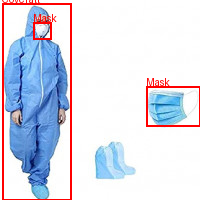

In [7]:
from PIL import Image, ImageDraw
import numpy as np

category_list = dataset['train'].features['objects'].feature['category'].names
id2label = {index: x for index, x in enumerate(category_list, start=0)}
label2id = {v: k for k, v in id2label.items()}

trainset = dataset['train']
im_file = trainset[0]
im = im_file['image']
annotations = im_file['objects']

draw = ImageDraw.Draw(im)

for bbox, category_id in zip(annotations['bbox'], annotations['category']):
    xmin, ymin, w, h = bbox
    xmax = xmin + w
    ymax = ymin + h
    draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
    draw.text((xmin, ymin-10), f"{id2label[category_id]}", fill='red')
im

In [8]:
from transformers import AutoImageProcessor

im_size = 480
processor = AutoImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    do_resize=True,
    size={"width": im_size, "height": im_size},
    use_fast=True,
)

import albumentations as A

train_augmentation_and_transform = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category'], clip=True, min_area=25, min_width=1, min_height=1),
)

val_augmentation_and_transform = A.Compose(
    [
        A.NoOp(),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category'], clip=True, min_area=1, min_width=1, min_height=1),
)

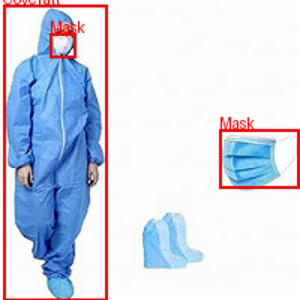

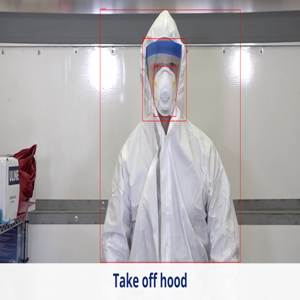

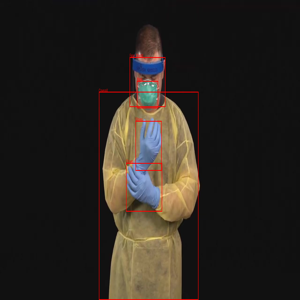

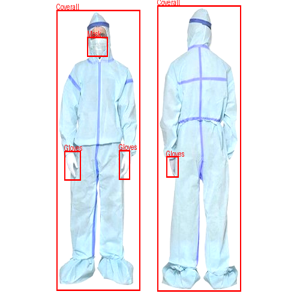

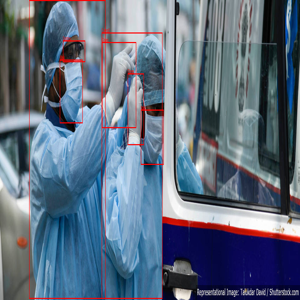

In [9]:
from IPython.display import display

for i in range(5):
    im = dataset['train'][i]['image']
    annotations = dataset['train'][i]['objects']

    output = train_augmentation_and_transform(
        image=np.array(im),
        bboxes=annotations['bbox'],
        category=annotations['category']
    )

    im = Image.fromarray(output['image'])
    categories, bboxes = output['category'], output['bboxes']

    draw = ImageDraw.Draw(im)
    for category, bbox in zip(categories, bboxes):
        xmin, ymin, w, h = bbox
        draw.rectangle([xmin, ymin, xmin+w, ymin+h], outline='red', width=2)
        draw.text((xmin, ymin-10), id2label[category], fill='red')
    display(im.resize([300, 300]))

In [10]:
from torch.utils.data import Dataset

class cppe5Dataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def format_annotations_as_coco(image_id, categories, bboxes):
        annotations = []
        for category, bbox in zip(categories, bboxes):
            formatted_annotations = {
                "image_id": image_id,
                "category_id": category,
                "bbox": list(bbox),
                "iscrowd": 0,
                "area": bbox[2] * bbox[3]
            }
            annotations.append(formatted_annotations)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        image_id = sample['image_id']
        image = sample['image']
        bboxes = sample['objects']['bbox']
        categories = sample['objects']['category']

        image = np.array(image.convert("RGB"))
        w, h = image.shape[0], image.shape[1]
        
        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category=categories)
            image = transformed['image']
            bboxes = transformed['bboxes']
            categories = transformed['category']
            
        formatted_annotations = self.format_annotations_as_coco(image_id, categories, bboxes)

        result = self.processor(
            images=image,
            annotations=formatted_annotations,
            return_tensors='pt'
        )

        result = {k: v[0] for k, v in result.items()}
        
        return result

In [12]:
train_dataset = cppe5Dataset(dataset['train'], processor, transform=None)
val_dataset = cppe5Dataset(dataset['val'], processor, transform=None)
test_dataset = cppe5Dataset(dataset['test'], processor, transform=None)
example = train_dataset[5]
print(example.keys())
print(example['labels'].keys())

dict_keys(['pixel_mask', 'pixel_values', 'labels'])
dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])


Image-0: torch.Size([3, 480, 480])


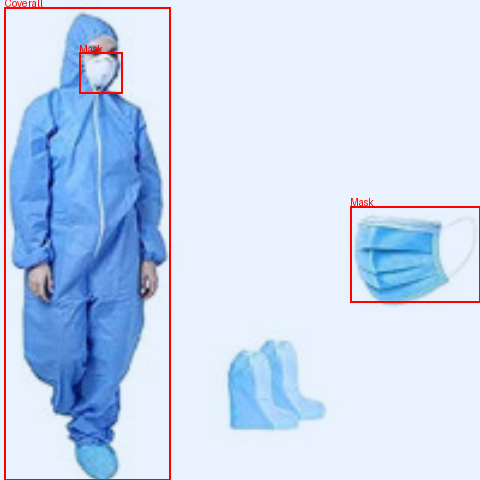

Image-1: torch.Size([3, 480, 480])


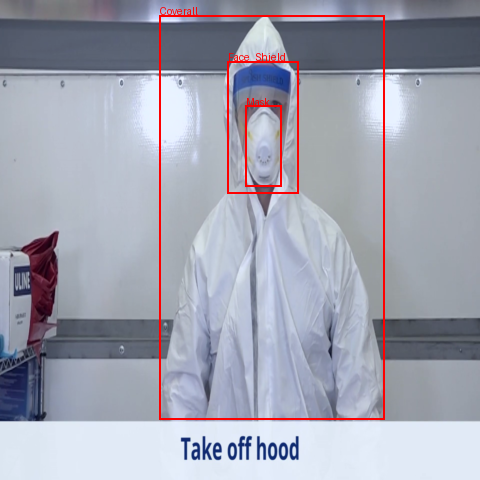

Image-2: torch.Size([3, 480, 480])


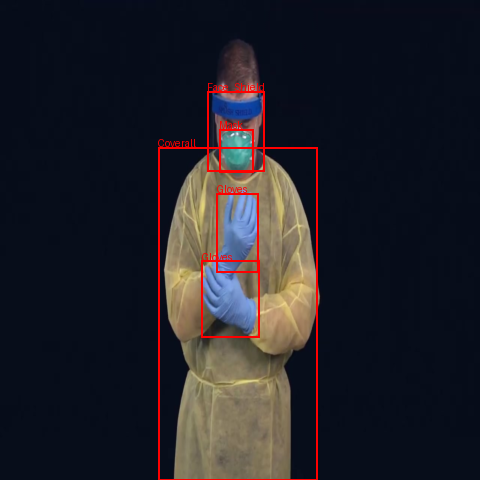

Image-3: torch.Size([3, 480, 480])


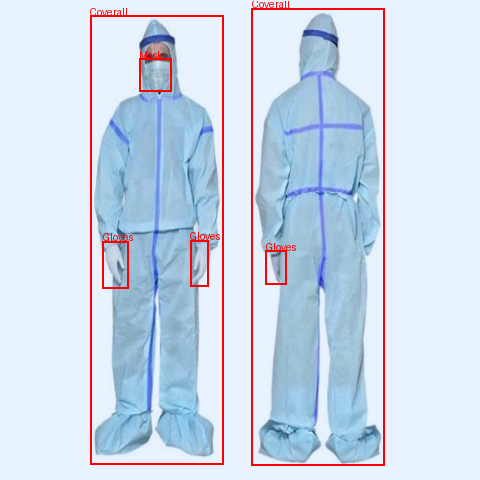

Image-4: torch.Size([3, 480, 480])


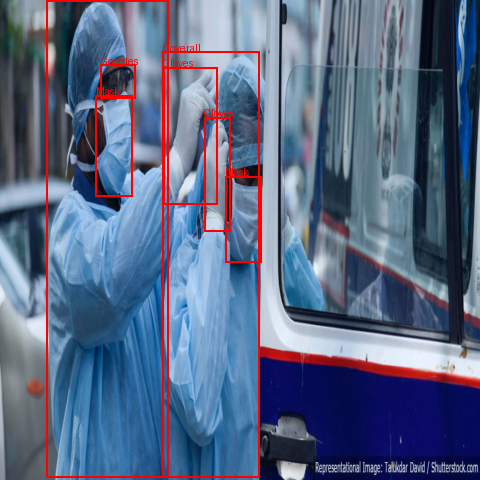

In [13]:
for i in range(5):
    sample = train_dataset[i]

    im = sample['pixel_values']
    print(f"Image-{i}: {im.shape}")
    im = im.numpy().transpose(1, 2, 0)
    im = (im - im.min()) / (im.max() - im.min()) * 255.
    im = Image.fromarray(im.astype(np.uint8))

    bboxes = sample['labels']['boxes']
    bboxes[:, :2] = bboxes[:, :2] - bboxes[:, 2:] / 2
    w, h = im.size
    bboxes = bboxes * np.array([w, h, w, h])[None]
    categories = sample['labels']['class_labels'].numpy()
    draw = ImageDraw.Draw(im)
    for bbox, category in zip(bboxes, categories):
        xmin, ymin, w, h = bbox
        draw.rectangle([xmin, ymin, xmin+w, ymin+h], outline='red', width=2)
        draw.text((xmin, ymin-10), id2label[category], fill='red')
    display(im)

In [14]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x['pixel_values'] for x in batch])
    data["labels"] = [x['labels'] for x in batch]
    return data

In [15]:
from dataclasses import dataclass
from transformers.image_transforms import center_to_corners_format
from torchmetrics.detection.mean_ap import MeanAveragePrecision

@dataclass
class ModelOutput:
    """
    A data container for model outputs.
    """
    logits: torch.Tensor
    pred_boxes: torch.Tensor

class MAPEvaluator:
    """
    - Processes model predictions and ground truth labels.
    - Converts bbox formats as needed.
    - Uses MeanAveragePrecision from torchmetrics to compute mAP and mAR.
    - Supports class-wise metrics.
    - Utilizes image processor for post processing
    """
    def __init__(self, processor, threshold=0.0, id2label=None):
        self.processor = processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """
        Collect image sizes across dataset as list of tensors with shape [batch_size, 2].
        The image sizes are needed to convert relative bboxes (normalized) into absolute coordinates.
        """
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x['size'] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        """
        Converts target bboxes from YOLO to Pascal VOC format.
        Scales normalized coordinates into absolute pixel values. (required by MeanAveragePrecision)
        """
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):
                height, width = size
                bboxes = torch.tensor(target['boxes'])
                bboxes = center_to_corners_format(bboxes)
                bboxes = bboxes * torch.tensor([[width, height, width, height]])

                labels = torch.tensor(target['class_labels'])
                post_processed_targets.append({
                    "boxes": bboxes,
                    "labels": labels
                })

        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        """
        Extract model predictions and wraps then in ModelOutput.
        Uses image processor post processing for object detection to filter and convert predictions to match gt format.
        """
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(
                logits=torch.tensor(batch_logits),
                pred_boxes=torch.tensor(batch_boxes)
            )
            post_processed_output = self.processor.post_process_object_detection(
                output,
                threshold=self.threshold,
                target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):
        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(processor=processor, threshold=0.01, id2label=id2label)

In [16]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True    # Num class mismatch
)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./detr_cppe5",
    num_train_epochs=50,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=10,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="tensorboard",
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,3.380841,0.001700,0.003500,0.001300,0.000000,0.001100,0.004800,0.007400,0.019700,0.115700,0.000000,0.025200,0.134900,0.005600,0.482800,0.000100,0.035500,0.000600,0.004500,0.000100,0.050000,0.002300,0.005800
2,No log,2.335352,0.005900,0.017700,0.002900,0.002000,0.004700,0.011200,0.017100,0.093200,0.214200,0.071300,0.101300,0.248400,0.012600,0.665000,0.000000,0.000000,0.006100,0.169100,0.000100,0.008300,0.010600,0.228600
3,No log,2.075619,0.038200,0.079400,0.031800,0.009500,0.018400,0.028700,0.088300,0.202300,0.253700,0.084200,0.180600,0.263900,0.130100,0.703900,0.000000,0.000000,0.010300,0.239900,0.000000,0.000000,0.050400,0.324900
4,No log,2.058404,0.047400,0.101400,0.038700,0.004900,0.011400,0.047200,0.085400,0.180700,0.220100,0.077300,0.120900,0.211400,0.202200,0.651100,0.000000,0.000000,0.010300,0.225300,0.000000,0.000000,0.024300,0.224300
5,No log,1.992116,0.048200,0.114700,0.036900,0.010000,0.035900,0.039200,0.076800,0.175000,0.227700,0.078600,0.180600,0.197700,0.168000,0.698900,0.000000,0.000000,0.006300,0.194900,0.000000,0.000000,0.066500,0.244400
6,2.601800,1.973644,0.056500,0.118600,0.047200,0.017300,0.017200,0.049700,0.103500,0.188500,0.232100,0.106500,0.135300,0.207000,0.220500,0.628900,0.000000,0.000000,0.019400,0.273000,0.000000,0.000000,0.042700,0.258700
7,2.601800,1.858876,0.071900,0.162400,0.056600,0.018300,0.046900,0.080000,0.118600,0.214500,0.253200,0.064000,0.179000,0.264100,0.250200,0.681700,0.006300,0.029000,0.016100,0.251700,0.000000,0.000000,0.087100,0.303700
8,2.601800,1.913385,0.069100,0.142900,0.061300,0.030200,0.048800,0.066400,0.105500,0.210900,0.235000,0.071900,0.156100,0.269100,0.251000,0.652800,0.001000,0.021000,0.021500,0.222500,0.000000,0.000000,0.071800,0.278800
9,2.601800,1.788609,0.102800,0.212200,0.085800,0.020100,0.054000,0.116900,0.144200,0.253600,0.282200,0.088300,0.179700,0.306300,0.361700,0.693900,0.027000,0.161300,0.022200,0.255100,0.003700,0.010400,0.099400,0.290500
10,2.601800,1.681738,0.113500,0.231100,0.100200,0.025600,0.084600,0.106300,0.157600,0.274800,0.305100,0.041200,0.227900,0.347500,0.379600,0.734400,0.045200,0.216100,0.041800,0.280900,0.000200,0.006300,0.100600,0.287800


TrainOutput(global_step=4250, training_loss=1.3956289888269762, metrics={'train_runtime': 2224.4873, 'train_samples_per_second': 19.106, 'train_steps_per_second': 1.911, 'total_flos': 7.310581744896e+18, 'train_loss': 1.3956289888269762, 'epoch': 50.0})

In [19]:
from pprint import pprint

metrics = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="eval")
pprint(metrics)

{'epoch': 50.0,
 'eval_loss': 1.1822454929351807,
 'eval_map': 0.3434,
 'eval_map_50': 0.6475,
 'eval_map_75': 0.2912,
 'eval_map_Coverall': 0.4775,
 'eval_map_Face_Shield': 0.3664,
 'eval_map_Gloves': 0.3001,
 'eval_map_Goggles': 0.1632,
 'eval_map_Mask': 0.4096,
 'eval_map_large': 0.5928,
 'eval_map_medium': 0.2794,
 'eval_map_small': 0.3895,
 'eval_mar_1': 0.3097,
 'eval_mar_10': 0.5504,
 'eval_mar_100': 0.5751,
 'eval_mar_100_Coverall': 0.7385,
 'eval_mar_100_Face_Shield': 0.7118,
 'eval_mar_100_Gloves': 0.4492,
 'eval_mar_100_Goggles': 0.4897,
 'eval_mar_100_Mask': 0.4863,
 'eval_mar_large': 0.7823,
 'eval_mar_medium': 0.4618,
 'eval_mar_small': 0.4457,
 'eval_runtime': 1.4899,
 'eval_samples_per_second': 19.464,
 'eval_steps_per_second': 2.685}


In [20]:
trainer.push_to_hub(commit_message="Initial commit", token="<Your-HF-Token>")

events.out.tfevents.1739121454.d7c374e845bd.31.1:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

events.out.tfevents.1739119229.d7c374e845bd.31.0:   0%|          | 0.00/80.9k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ekagrag99/detr_cppe5/commit/53262350e23abe88bbc03273f810ab14a73a1599', commit_message='Initial commit', commit_description='', oid='53262350e23abe88bbc03273f810ab14a73a1599', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ekagrag99/detr_cppe5', endpoint='https://huggingface.co', repo_type='model', repo_id='ekagrag99/detr_cppe5'), pr_revision=None, pr_num=None)

In [21]:
import torch
import requests
from PIL import Image, ImageDraw

device = "cuda"

url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
image = Image.open(requests.get(url, stream=True).raw)

In [22]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

model_repo = "ekagrag99/detr_cppe5"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

inputs = processor(images=[image], return_tensors="pt")
inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs)
target_sizes = torch.tensor([image.size[::-1]])

result = processor.post_process_object_detection(outputs, threshold=0.4, target_sizes=target_sizes)[0]

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

Detected Gloves with confidence 0.797 at location [543.17, 658.98, 596.52, 711.69]
Detected Mask with confidence 0.424 at location [982.83, 3.96, 1110.13, 131.7]
Detected Gloves with confidence 0.972 at location [429.91, 389.45, 594.06, 535.29]
Detected Coverall with confidence 0.658 at location [152.43, 290.82, 721.7, 744.71]
Detected Mask with confidence 0.962 at location [351.11, 156.93, 500.29, 281.2]
Detected Coverall with confidence 0.853 at location [144.3, 9.61, 713.5, 742.98]
Detected Gloves with confidence 0.596 at location [21.18, 603.43, 205.83, 740.12]
Detected Gloves with confidence 0.966 at location [562.93, 292.68, 707.82, 429.62]


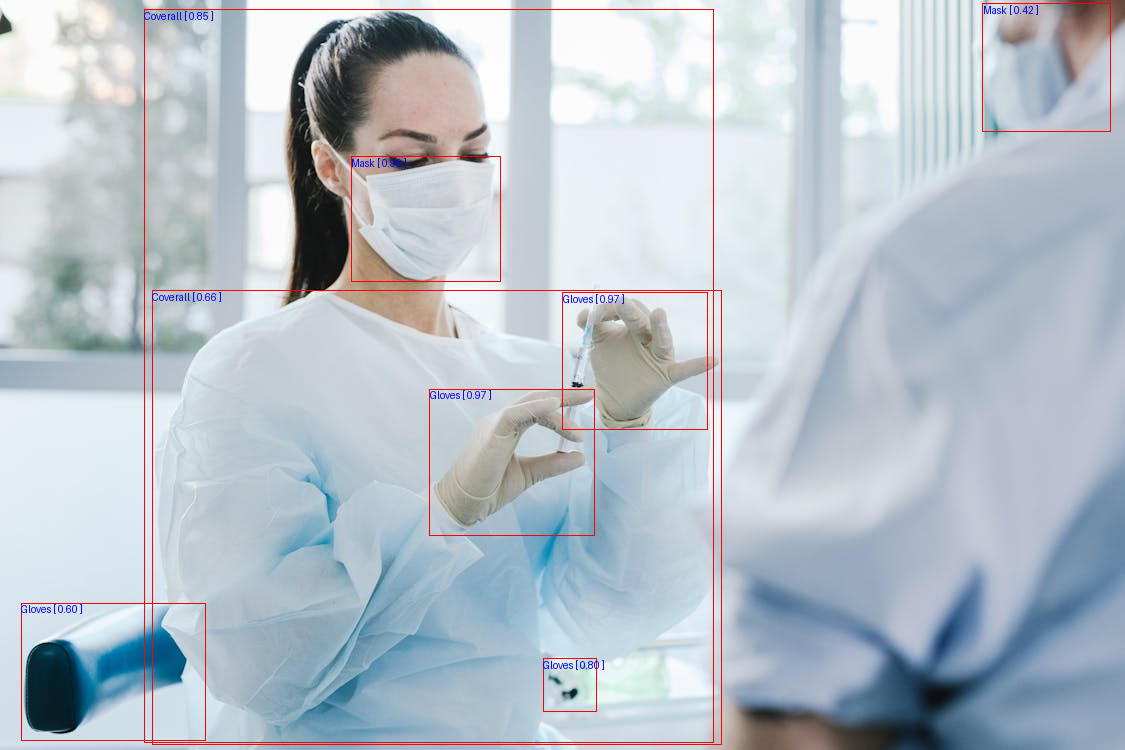

In [23]:
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    text_label = model.config.id2label[label.item()]
    draw.text((x, y), f"{text_label} [ {score.item():.2f} ]", fill="blue")

image_with_boxes